In [1]:
import json
import numpy as np
import os 

In [2]:
dataset = "emotion"
dataset_size = 2000
# dataset = "imdb"
# dataset_size = 25000
aggregator = "norm_lime"

In [3]:
lime_num_samples = 5000
# lime_num_samples = 1000
experiment_dir = f"../experiments/{dataset}/lime/k_all-n_{lime_num_samples}-mask_remove"

In [4]:
gt_file = os.path.join(experiment_dir, f"global_explanation_full-aggregator_{aggregator}.json")
gt_results = json.load(open(gt_file))

In [5]:
import re

sampled_files_template = r"^global_explanation-sampler_.+-n_.+-aggregator_.+\.json"
sampled_files = [f for f in os.listdir(experiment_dir) if re.match(sampled_files_template, f)]
sampled_files

['global_explanation-sampler_variation_ratio-n_20-aggregator_norm_lime.json',
 'global_explanation-sampler_el2n-n_100-aggregator_norm_lime.json',
 'global_explanation-sampler_variation_ratio-n_200-aggregator_norm_lime.json',
 'global_explanation-sampler_uniform-n_100-aggregator_norm_lime.json',
 'global_explanation-sampler_entropy-n_500-aggregator_norm_lime.json',
 'global_explanation-sampler_el2n-n_10-aggregator_norm_lime.json',
 'global_explanation-sampler_uniform-n_10-aggregator_norm_lime.json',
 'global_explanation-sampler_variation_ratio-n_50-aggregator_norm_lime.json',
 'global_explanation-sampler_entropy-n_50-aggregator_norm_lime.json',
 'global_explanation-sampler_entropy-n_1000-aggregator_norm_lime.json',
 'global_explanation-sampler_el2n-n_500-aggregator_norm_lime.json',
 'global_explanation-sampler_entropy-n_100-aggregator_norm_lime.json',
 'global_explanation-sampler_uniform-n_500-aggregator_norm_lime.json',
 'global_explanation-sampler_entropy-n_20-aggregator_norm_lime.jso

In [6]:
def get_sample_size_from_file(file):
	return int(re.findall(r"-n_(\d+)", file)[0])

def get_sampler_from_file(file):
	return re.findall(r"-sampler_(.+)-n", file)[0]

def get_aggregator_from_file(file):
	return re.findall(r"-aggregator_(.+)\.json", file)[0]

sample_sizes = set([get_sample_size_from_file(file) for file in sampled_files])
sample_sizes = sorted(list(sample_sizes))

sampler_names = set([get_sampler_from_file(file) for file in sampled_files])
sampler_names = sorted(list(sampler_names))

aggregator_names = set([get_aggregator_from_file(file) for file in sampled_files])
aggregator_names = sorted(list(aggregator_names))

In [7]:
sampled_results = [
	{
        "sampler": get_sampler_from_file(f),
        "sample_size": get_sample_size_from_file(f),
        "aggregator": get_aggregator_from_file(f),
        "global_explanation": json.load(open(os.path.join(experiment_dir, f)))
    }
    for f in sampled_files
]

In [8]:
for category in gt_results:
	print(f"Category: {category}")
	print(f"Number of tokens in GT: {len(gt_results[category])}")

Category: fear
Number of tokens in GT: 1199
Category: surprise
Number of tokens in GT: 537
Category: joy
Number of tokens in GT: 2589
Category: sadness
Number of tokens in GT: 2116
Category: love
Number of tokens in GT: 1099
Category: anger
Number of tokens in GT: 1340


In [9]:
top_k = 10

def get_top_k_tokens_per_category(analysis_results: dict, top_k = 10):
	top_k_tokens = {}
	for category in analysis_results:
		tokens = analysis_results[category]
		tokens = [(t, v) for t, v in tokens.items()]
		tokens = sorted(tokens, key=lambda x: np.abs(x[1]), reverse=True)
		tokens = tokens[:top_k]
		top_k_tokens[category] = {t: v for t, v in tokens}
	return top_k_tokens
	
print(f"Top {top_k} tokens per category in ground truth")
print()
for category, tokens in get_top_k_tokens_per_category(gt_results, top_k).items():
	print(f"#{category}")
	for token, value in tokens.items():
		print(f"{token}: {value}")
	print()
print()

Top 10 tokens per category in ground truth

#fear
distraught: 0.9225850999417592
shy: 0.8795350560672226
pressured: 0.8426262409186993
distressed: 0.8019797886548911
restless: 0.7811262786623255
hesitant: 0.7543501951331095
frightened: 0.7536159816491047
frantic: 0.7467033224108032
shaky: 0.729968986609039
fearful: 0.7022402720706599

#surprise
impressed: 0.9225224554049689
dazed: 0.8701632428605359
amazed: 0.8657137224058118
curious: 0.8143948687986736
shocked: 0.7933648137471135
stunned: 0.7729145374283336
surprised: 0.7046270412952412
funny: 0.5195839081738498
amazing: 0.3530461030224525
weird: 0.33690489317291167

#joy
winning: 0.43570588093295254
entertained: 0.37442486525552654
decent: 0.3697268485076623
benevolent: 0.2481928904626182
convinced: 0.23762154741087652
delicious: 0.23095829389103584
innocent: 0.22696858699510652
unique: 0.22593244297165593
glad: 0.22281600142876418
cool: 0.22209815072871353

#sadness
defective: 0.947936092591327
sentimental: 0.8741461796528132
disadv

In [10]:
def compute_mae(gt_results, sampled_resutls, top_k = 10):
	# computes MAE on top_k tokens per category
	# if a token from sampled is not in gt, it gets skipped in MAE computation
	mae_per_category = []
	gt_top_k = get_top_k_tokens_per_category(gt_results, top_k)
	for category in gt_top_k:
		mae = 0
		gt_tokens = gt_top_k[category]
		sampled_tokens = sampled_resutls.get(category, {})
		for token in gt_tokens:
			if token in sampled_tokens:
				mae += np.abs(gt_tokens[token] - sampled_tokens[token])
			else:
				mae += np.abs(gt_tokens[token])

		mae_per_category.append(mae / top_k) # (top_k * len(gt_top_k))
	return np.mean(mae_per_category)

def recall_at_k(gt_results, sampled_results, top_k = 10):
	# computes how many tokens from top_k in gt are in top_k in sampled
	recall_per_category = []
	gt_top_k = get_top_k_tokens_per_category(gt_results, top_k)
	sampled_top_k = get_top_k_tokens_per_category(sampled_results, top_k)
	for category in gt_top_k:
		recall = 0
		gt_tokens = gt_top_k[category]
		sampled_tokens = sampled_top_k.get(category, {})
		for token in gt_tokens:
			if token in sampled_tokens:
				recall += 1
		recall_per_category.append(recall / top_k)
	return np.mean(recall_per_category)

In [11]:
for sampled_results_dict in sampled_results:
	mae = compute_mae(gt_results, sampled_results_dict['global_explanation'], top_k)
	sampled_results_dict['mae'] = mae
	recall = recall_at_k(gt_results, sampled_results_dict['global_explanation'], top_k)
	sampled_results_dict['recall'] = recall

In [12]:
import pandas as pd

results_df = pd.DataFrame(sampled_results)
results_df.sort_values(by=['sample_size'])

,sampler,sample_size,aggregator,global_explanation,mae,recall
24,entropy,10,norm_lime,"{'joy': {'[CLS]': 0.0, 'one': 0.00052047849562...",0.664223,0.000000
18,variation_ratio,10,norm_lime,"{'joy': {'[CLS]': 0.0, 'one': 0.00052047849562...",0.664223,0.000000
5,el2n,10,norm_lime,"{'sadness': {'[CLS]': 0.0, 'i': 0.003413360529...",0.664223,0.000000
6,uniform,10,norm_lime,"{'fear': {'[CLS]': 0.0, 'i': 8.553877678666627...",0.645035,0.066667
0,variation_ratio,20,norm_lime,"{'joy': {'[CLS]': 0.0, 'one': 0.00052047849562...",0.660156,0.016667
15,el2n,20,norm_lime,"{'sadness': {'[CLS]': 0.0, 'i': 0.001511544214...",0.664223,0.000000
14,uniform,20,norm_lime,"{'fear': {'[CLS]': 0.0, 'i': 6.082735850809480...",0.637773,0.083333
13,entropy,20,norm_lime,"{'joy': {'[CLS]': 0.0, 'one': 0.00081020072226...",0.660056,0.016667
8,entropy,50,norm_lime,"{'joy': {'[CLS]': 0.0, 'one': 0.00081020072226...",0.656125,0.033333
20,uniform,50,norm_lime,"{'fear': {'[CLS]': 0.0, 'i': 6.150706162375125...",0.612332,0.133333


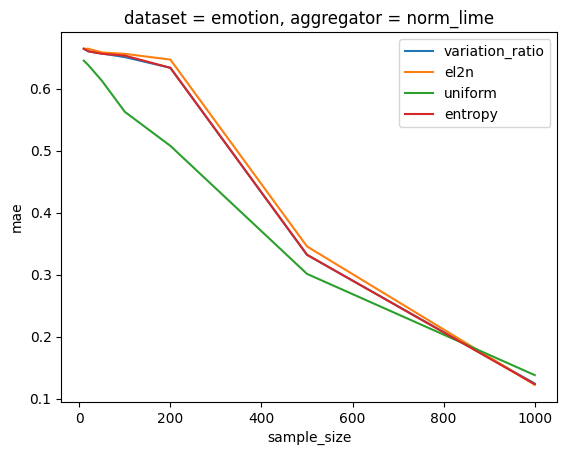

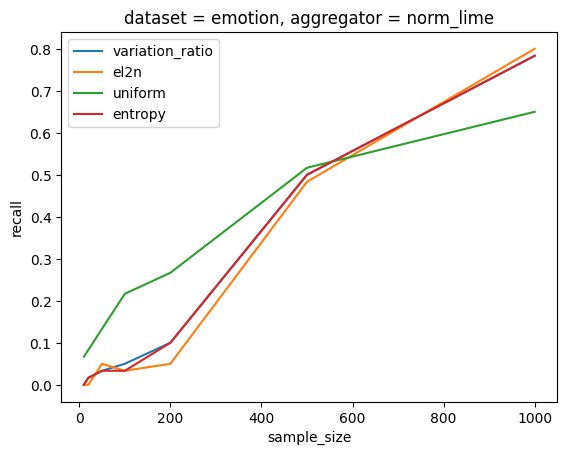

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data=results_df, x="sample_size", y="mae", hue="sampler")
# plt.xscale("log")
plt.legend()
plt.title(f"dataset = {dataset}, aggregator = {aggregator}")
plt.savefig(f"{dataset}_mae_vs_sample_size.png", dpi=200)
plt.show()

sns.lineplot(x="sample_size", y="recall", hue="sampler", data=results_df)
# plt.xscale("log")
plt.legend()
plt.title(f"dataset = {dataset}, aggregator = {aggregator}")
plt.savefig(f"{dataset}_recall_vs_sample_size.png", dpi=200)
plt.show()